# <font color='blue'>Mini-Projeto</font>
## Prever a Intenção de Compra de Usuários de E-Commerce

Definição do Problema:

Avaliar quais atributos influenciam um usuário na compra de produtos online e construir um modelo preditivo para realizar previsões de compras futuras.

Usaremos como fonte de dados o dataset:

Online Shoppers Purchasing Intention Dataset

https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

O conjunto de dados consiste em vetores de recursos pertencentes a 12.330 sessões online. O conjunto de dados foi formado de modo que cada sessão pertença a um usuário diferente em um período de 1 ano para evitar qualquer tendência para uma campanha específica, dia especial, usuário, perfil ou período.

O conjunto de dados consiste em 10 atributos numéricos e 8 categóricos. O atributo 'Revenue' pode ser usado como o rótulo da classe.

##### Importante

Iniciei o notebook em pyspark mas por questão de falta de tempo eu mudei a estratégia para pandas. 

## Importando os Pacotes

In [12]:
# Imports
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import category_encoders as ce
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import Normalizer
import sklearn
import matplotlib
import warnings
import category_encoders as ce
warnings.filterwarnings('ignore')

In [3]:
# Carregando os dados
df_original = pd.read_csv('data/online_shoppers_intention.csv')
df_original.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Dados:

* As colunas Administrativo, Duração administrativa, Informativo, Duração informativo, Relacionado ao produto e Duração relacionada ao produto: representam o número de diferentes tipos de páginas visitadas pelo visitante nessa sessão e o tempo total gasto em cada uma dessas categorias de página. 

* Taxa de rejeição, Taxa de saída e Valor da página: representam as métricas medidas pelo "Google Analytics" para cada página no site de comércio eletrônico. 

* Taxa de rejeição de uma página da web: refere-se à porcentagem de visitantes que entram no site a partir dessa página e saem ("rejeição") sem acionar outras solicitações ao servidor durante essa sessão. 

* Taxa de saída para uma página da web: específica é calculado como a porcentagem que foi a última na sessão, para todas as exibições de página a página. 

* Valor da página: representa o valor médio para uma página da web que um usuário visitou antes de concluir uma transação de comércio eletrônico. 

* Dia especial: indica a proximidade do horário de visita do site a um dia especial específico (por exemplo, dia das mães, dia dos namorados) em que as sessões têm mais probabilidade de serem finalizadas com a transação. 

* O conjunto de dados também inclui o tipo de sistema operacional, navegador, região, tipo de tráfego, tipo de visitante como visitante novo ou recorrente, um valor booleano indicando se a data da visita é final de semana e mês do ano.

* A variável observada (Revenue) é booleana, com True se a sessão gerou receita e False se não gerou.

## Análise Exploratória

In [79]:
# Número de linhas e columnas
df_original.shape

(12330, 18)


In [166]:
# Tipos de Dados
df_original.dtypes

Administrative             float64
Administrative_Duration    float64
Informational              float64
Informational_Duration     float64
ProductRelated             float64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

In [167]:
# Verificando valores missing
print(df_original.isna().sum())

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64


In [4]:
# Removendo as linhas com valores missing
df_original.dropna(inplace = True)

In [171]:
# Shape
df_original.shape

(12316, 18)

In [170]:
# Verificando Valores Únicos
df_original.nunique()

Administrative               27
Administrative_Duration    3336
Informational                17
Informational_Duration     1259
ProductRelated              311
ProductRelated_Duration    9552
BounceRates                1872
ExitRates                  4777
PageValues                 2704
SpecialDay                    6
Month                        10
OperatingSystems              8
Browser                      13
Region                        9
TrafficType                  20
VisitorType                   3
Weekend                       2
Revenue                       2
dtype: int64

Para fins de visualização, dividiremos os dados em variáveis contínuas e categóricas. Trataremos todas as variáveis com menos de 30 entradas únicas como categóricas.

In [5]:
# Preparando os dados para o plot

# Cria uma cópia do dataset original
df = df_original.copy()

# Listas vazias para os resultados
continuous = []
categorical = []

# Loop pelas colunas
for c in df.columns[:-1]:
    if df.nunique()[c] >= 30:
        continuous.append(c)
    else:
        categorical.append(c)

In [173]:
continuous

['Administrative_Duration',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues']

In [174]:
# Variáveis contínuas
df[continuous].head()

,Administrative_Duration,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues
0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0
1,0.0,0.0,2.0,64.000000,0.00,0.10,0.0
2,-1.0,-1.0,1.0,-1.000000,0.20,0.20,0.0
3,0.0,0.0,2.0,2.666667,0.05,0.14,0.0
4,0.0,0.0,10.0,627.500000,0.02,0.05,0.0


In [201]:
# Variáveis categóricas
df[categorical].head()

,Administrative,Informational,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend
0,0.0,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False
1,0.0,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False
2,0.0,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False
3,0.0,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False
4,0.0,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True


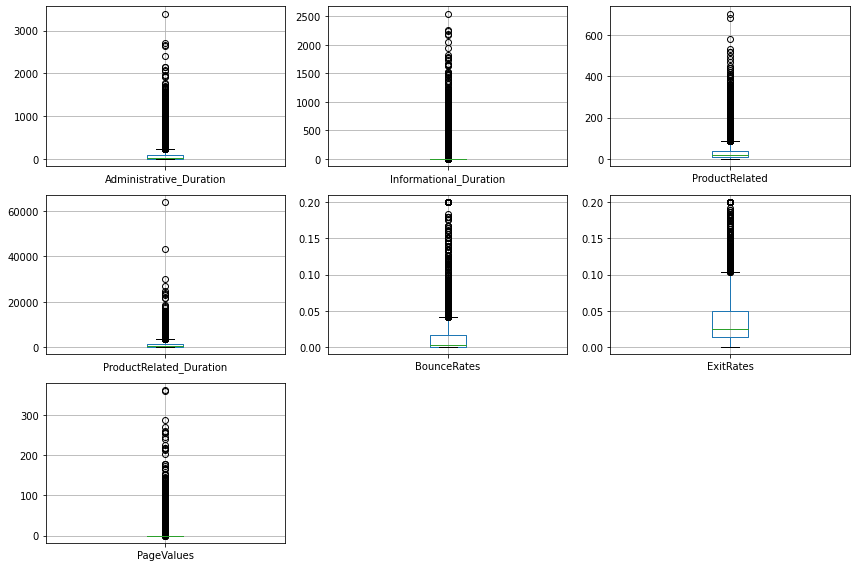

In [176]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i, col in enumerate(continuous):
    plt.subplot(3, 3, i + 1);
    df.boxplot(col);
    plt.tight_layout()
    
plt.savefig('imagens/boxplot1.png')

Variáveis contínuas parecem extremamente distorcidas. Vamos aplicar transformação de log para melhor visualização.

In [177]:
# Transformação de log nas variáveis contínuas
df[continuous] = np.log1p(1 + df[continuous])

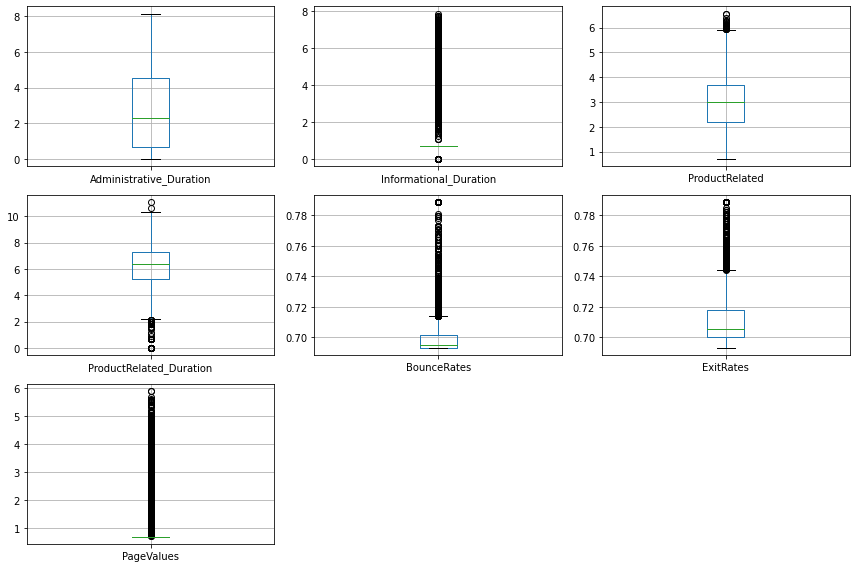

In [178]:
# Plot das variáveis contínuas

# Tamanho da área de plotagem
fig = plt.figure(figsize = (12,8))

# Loop pelas variáveis contínuas
for i,col in enumerate(continuous):
    plt.subplot(3,3,i+1);
    df.boxplot(col);
    plt.tight_layout()
plt.savefig('imagens/boxplot2.png')

Matriz de Correlação Entre Variáveis Contínuas.

<AxesSubplot:>

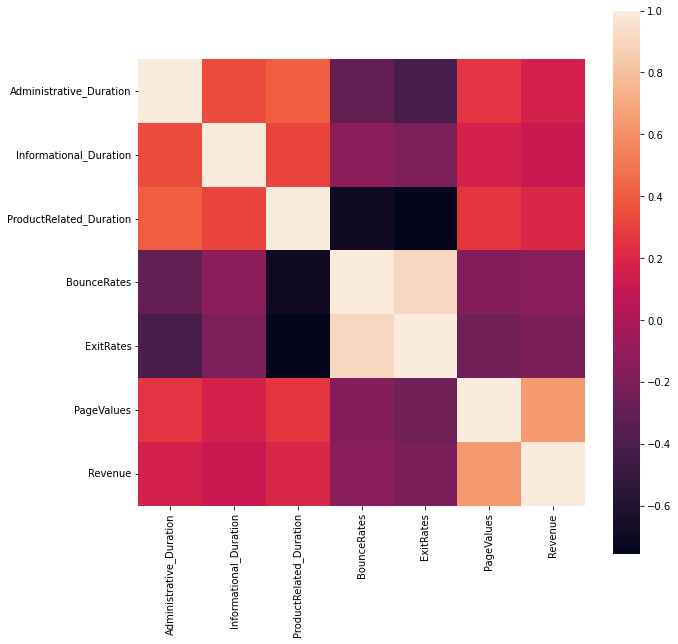

In [179]:
# Área de plotagem
plt.figure(figsize = (10,10))

# Matriz de Correlação 
sns.heatmap(df[['Administrative_Duration',
                'Informational_Duration',  
                'ProductRelated_Duration',
                'BounceRates', 
                'ExitRates', 
                'PageValues',
                'Revenue']].corr(), vmax = 1., square = True)

Visualização de gráficos de variáveis categóricas para analisar como a variável de destino é influenciada por elas.

<AxesSubplot:title={'center':'Venda ou Não'}, xlabel='Revenue', ylabel='count'>

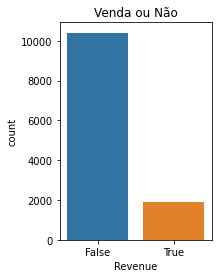

In [180]:
# Countplot Venda ou Não
plt.subplot(1,2,2)
plt.title("Venda ou Não")
sns.countplot(df['Revenue'])

<AxesSubplot:xlabel='VisitorType', ylabel='count'>

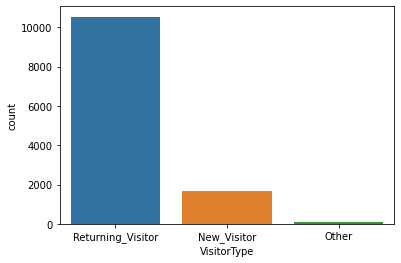

In [181]:
# Countplot Tipo de Visitante
plt.xlabel("Tipo de Visitante")
sns.countplot(df['VisitorType'])

<AxesSubplot:xlabel='VisitorType'>

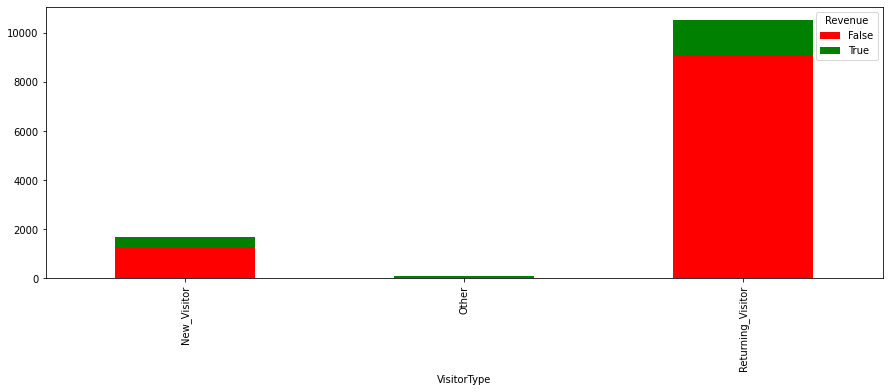

In [182]:
# Stacked Bar Tipo de Visitante x Revenue
pd.crosstab(df['VisitorType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

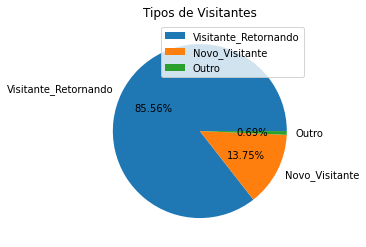

In [183]:
# Pie Chart Tipos de Visitantes
labels = ['Visitante_Retornando', 'Novo_Visitante', 'Outro']
plt.title("Tipos de Visitantes")
plt.pie(df['VisitorType'].value_counts(), labels = labels, autopct = '%.2f%%')
plt.legend()

<AxesSubplot:title={'center':'Final de Semana ou Não'}, xlabel='Weekend', ylabel='count'>

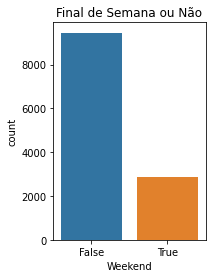

In [184]:
# Countplot Final de Semana ou Não
plt.subplot(1,2,1)
plt.title("Final de Semana ou Não")
sns.countplot(df['Weekend'])

<AxesSubplot:xlabel='Weekend'>

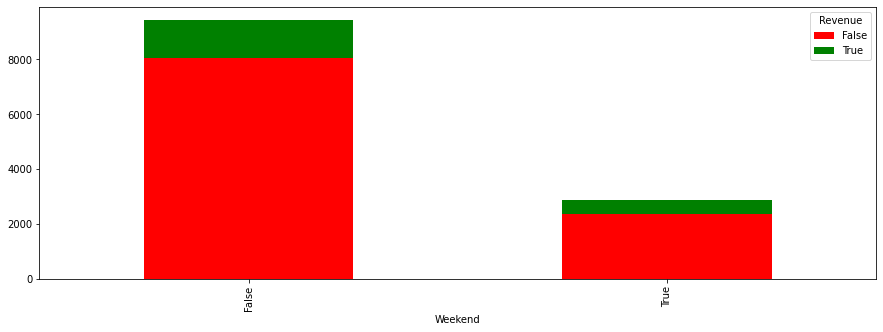

In [185]:
# Stacked Bar Final de Semana x Revenue
pd.crosstab(df['Weekend'], df['Revenue']).plot(kind = 'bar', 
                                               stacked = True, 
                                               figsize = (15, 5), 
                                               color = ['red', 'green'])

<AxesSubplot:title={'center':'Tipos de Sistemas Operacionais'}, xlabel='OperatingSystems', ylabel='count'>

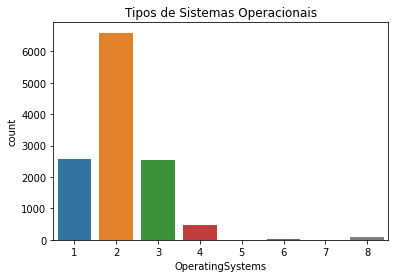

In [186]:
# Countplot Tipos de Sistemas Operacionais
#plt.figure(figsize = (15,6))
plt.title("Tipos de Sistemas Operacionais")
plt.xlabel("Sistema Operacional Usado")
sns.countplot(df['OperatingSystems'])

<AxesSubplot:xlabel='OperatingSystems'>

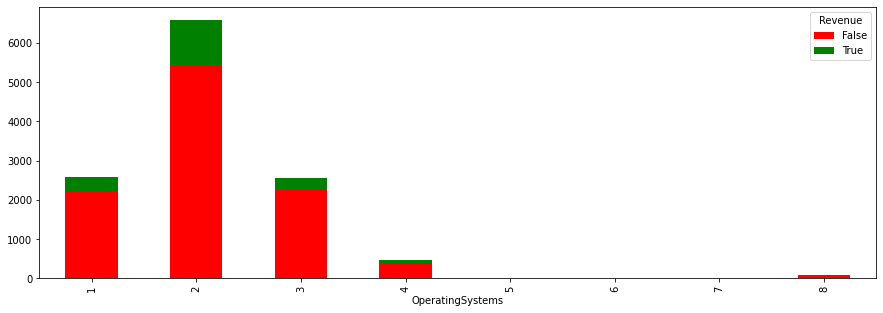

In [187]:
# Stacked Bar Tipo de SO x Revenue
pd.crosstab(df['OperatingSystems'], df['Revenue']).plot(kind = 'bar', 
                                                        stacked = True, 
                                                        figsize = (15, 5), 
                                                        color = ['red', 'green'])

<AxesSubplot:title={'center':'Tipos de Tráfego'}, xlabel='TrafficType', ylabel='count'>

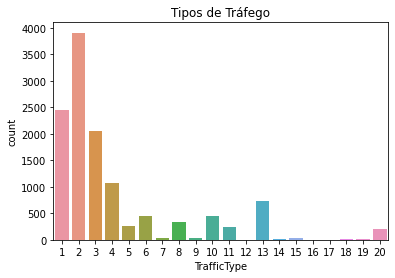

In [188]:
# Countplot Tipo de Tráfego
plt.title("Tipos de Tráfego")
plt.xlabel("Tipo de Tráfego")
sns.countplot(df['TrafficType'])

<AxesSubplot:xlabel='TrafficType'>

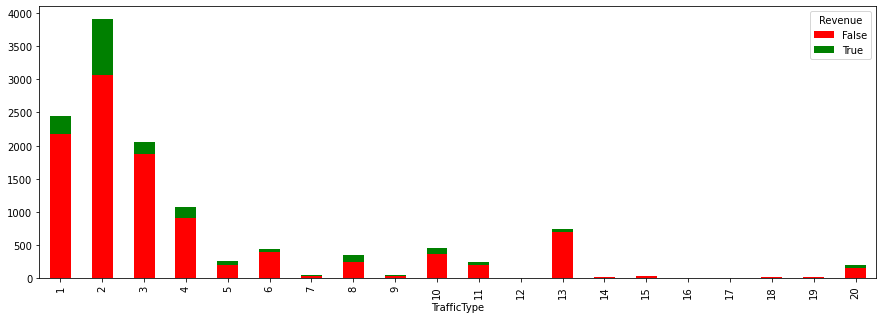

In [189]:
# Stacked Bar Tipos de Tráfego x Revenue
pd.crosstab(df['TrafficType'], df['Revenue']).plot(kind = 'bar', 
                                                   stacked = True, 
                                                   figsize = (15, 5), 
                                                   color = ['red', 'green'])

## Pré-Processamento dos Dados

Agora que já exploramos e conhecemos o dataset vamos realizar processamentos nos dados os quais serviram de entrada para um algoritmo a fim de construir um modelo.

Decidi seguir sem o pyspark porque tenho pouco tempo para realizar o projeto e vários pacotes do pyspark estão em conflito durante a minha instalação.

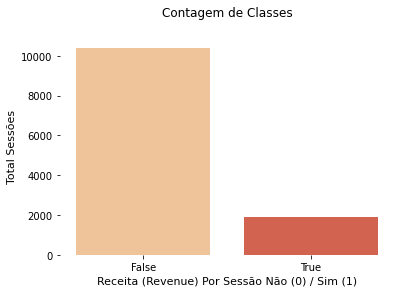

In [274]:
# Verificando se a variável observada está balanceada
sns.countplot(df.Revenue, palette = "OrRd")
plt.box(False)
plt.xlabel('Receita (Revenue) Por Sessão Não (0) / Sim (1)', fontsize = 11)
plt.ylabel('Total Sessões', fontsize = 11)
plt.title('Contagem de Classes\n')
plt.show()

Obsevação:

Para impedir que as informações sobre a distribuição do conjunto de teste vazem em seu modelo, o ideal é aplicar a padronização em separado nos dados de treino e de teste, ajustando o redimensionador apenas aos dados de treinamento, padronizando então os conjuntos de treinamento e teste com esse redimensionador. Ao ajustar o redimensionador no conjunto de dados completo antes da divisão em treino e teste, informações sobre o conjunto de testes são usadas para transformar o conjunto de treinamento.


#### Vamos agora testar alguns algoritmos que podem nos fornecer os melhores modelos

In [9]:
# Separa X e y
X = df.iloc[:, 0:-1]  
y = df.iloc[:, 17]

# Divisão em Dados de Treino e Teste.
X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size = 0.3, random_state = 42)

scaler = RobustScaler()
encoder = ce.TargetEncoder(cols=categorical)
# putting numeric columns to scaler and categorical to encoder
num_transformer = make_pipeline(scaler)
cat_transformer = make_pipeline(encoder)

# getting together our scaler and encoder with preprocessor

preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, continuous),
                    ('cat', cat_transformer, categorical)])


In [10]:
###########################################################################################################################
#                                             Logistic Regressor
###########################################################################################################################

# Cria o modelo
modelo = LogisticRegression(class_weight='balanced',random_state=42)

# Cria o pipeline
pipe = make_pipeline(preprocessor,modelo)

param = {
    'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'logisticregression__penalty': ['none', 'l1', 'l2', 'elasticnet']
    }

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=param, cv=kfold, n_jobs=-1, return_train_score=True)

# giving all values to pipeline
grid.fit(X_treino, y_treino)

# make predictions on test set
previsoes = grid.predict(X_teste)

# Dicionário de métricas e metadados
LR_dict = {'Modelo':'',
               'Versão':'2',
               'Kernel':'Dados Padronizados',
               'Precision':precision_score(previsoes, y_teste),
               'Recall':recall_score(previsoes, y_teste),
               'F1 Score':f1_score(previsoes, y_teste),
               'Acurácia':accuracy_score(previsoes, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes)}# Print
print("Métricas em Teste:\n")
LR_dict

Métricas em Teste:



{'Modelo': '',
 'Versão': '2',
 'Kernel': 'Dados Padronizados',
 'Precision': 0.7755474452554745,
 'Recall': 0.48963133640552997,
 'F1 Score': 0.6002824858757062,
 'Acurácia': 0.8468200270635995,
 'AUC': 0.8173892294596408}

In [18]:
###########################################################################################################################
#                                             LightGBM
###########################################################################################################################
modelo = lgb.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=42, class_weight='balanced')

# Grid de hiperparâmetros
param = {'lgbmclassifier__num_leaves': [20,40],
         'lgbmclassifier__min_child_samples': [5,10],
         'lgbmclassifier__max_depth': [5,10],
         'lgbmclassifier__learning_rate': [0.05,0.1]
        }
    
# giving all values to pipeline
pipe = make_pipeline(preprocessor,modelo)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=param, cv=kfold, n_jobs=-1, return_train_score=True)

# giving all values to pipeline
grid.fit(X_treino, y_treino)

# make predictions on test set
previsoes = grid.predict(X_teste)

# Dicionário de métricas e metadados
LightGBM_dict = {'Modelo':'LightGBM',
               'Versão':'2',
               'Kernel':'Dados Padronizados',
               'Precision':precision_score(previsoes, y_teste),
               'Recall':recall_score(previsoes, y_teste),
               'F1 Score':f1_score(previsoes, y_teste),
               'Acurácia':accuracy_score(previsoes, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes)}# Print
print("Métricas em Teste:\n")
LightGBM_dict

Métricas em Teste:



{'Modelo': 'LightGBM',
 'Versão': '2',
 'Kernel': 'Dados Padronizados',
 'Precision': 0.7372262773722628,
 'Recall': 0.5650349650349651,
 'F1 Score': 0.6397466349960412,
 'Acurácia': 0.8768606224627875,
 'AUC': 0.8192010001414856}

In [17]:
###########################################################################################################################
#                                             Random Forest
###########################################################################################################################

# Cria o modelo
modelo = RandomForestClassifier(class_weight='balanced')

# Grid de hiperparâmetros
param = {'randomforestclassifier__bootstrap': [True, False],
         'randomforestclassifier__max_depth': [3, 6, 10],
         'randomforestclassifier__max_features': ['auto', 'sqrt'],
         'randomforestclassifier__min_samples_leaf': [1, 2, 4],
         'randomforestclassifier__n_estimators': [200,500]
        }
    
# giving all values to pipeline
pipe = make_pipeline(preprocessor,modelo)

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(pipe, param_grid=param, cv=kfold, n_jobs=-1, return_train_score=True)

# giving all values to pipeline
grid.fit(X_treino, y_treino)

# make predictions on test set
previsoes = grid.predict(X_teste)

# Dicionário de métricas e metadados
RF_dict = {'Modelo':'RF',
               'Versão':'2',
               'Kernel':'Dados Padronizados',
               'Precision':precision_score(previsoes, y_teste),
               'Recall':recall_score(previsoes, y_teste),
               'F1 Score':f1_score(previsoes, y_teste),
               'Acurácia':accuracy_score(previsoes, y_teste),
               'AUC':roc_auc_score(y_teste, previsoes)}# Print
print("Métricas em Teste:\n")
RF_dict

Métricas em Teste:



{'Modelo': 'RF',
 'Versão': '2',
 'Kernel': 'Dados Padronizados',
 'Precision': 0.7755474452554745,
 'Recall': 0.5727762803234502,
 'F1 Score': 0.6589147286821706,
 'Acurácia': 0.8809201623815968,
 'AUC': 0.8374082952365711}

In [19]:
# Concatena todos os dicionários em um dataframe do Pandas
resumo = pd.DataFrame({'LR_dic':pd.Series(LR_dict),
                       'LightGBM_dict':pd.Series(LightGBM_dict),
                       'RF_dict':pd.Series(RF_dict)})

De acordo com a tabela abaixo pode-se perceber que de acordo com as métricas como precision e recall o modelo construído com o algoritmo Random Forest foi o que apresentou o melhor resultado. Ao realizar testes com outras abordagens, realizar seleção de atributos e também ao tunar outros hyperparâmetros provavelmente obteríamos uma melhora no modelo.

In [20]:
# Print
resumo

,LR_dic,LightGBM_dict,RF_dict
Modelo,,LightGBM,RF
Versão,2,2,2
Kernel,Dados Padronizados,Dados Padronizados,Dados Padronizados
Precision,0.775547,0.737226,0.775547
Recall,0.489631,0.565035,0.572776
F1 Score,0.600282,0.639747,0.658915
Acurácia,0.84682,0.876861,0.88092
AUC,0.817389,0.819201,0.837408
